In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import os
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

In [16]:
# function to the virusSpreading
def virus_spreading(t, y, beta, mu, nu):
    S = y[0]
    I = y[1]
    R = y[2]
    D = y[3]

    dS_dt = -beta * S * I
    dI_dt = beta * S * I - mu * I
    dR_dt = nu * mu * I
    dD_dt = (1 - nu) * mu * I

    return [dS_dt, dI_dt, dR_dt, dD_dt]

In [17]:
#function to the simulation of the VirusSpreading   
def sim_virus_spreading(beta, verbose=False):
    S0 = 99
    I0 = 1
    R0 = 0
    D0 = 0
    y0 = [S0, I0, R0, D0]
    t_span = np.linspace(0, 500, 501)
    mu = 0.0175
    nu = 0.99

    def model(y, t):
        return virus_spreading(t, y, beta, mu, nu)

    ySol = odeint(model, y0, t_span)
    if verbose:
        plt.plot(t_span, ySol)
        plt.legend(["Susceptible", "Infected", "Recovered", "Dead"])
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title('Virus Spreading Simulation')
        plt.show()

    return np.column_stack((t_span, ySol))

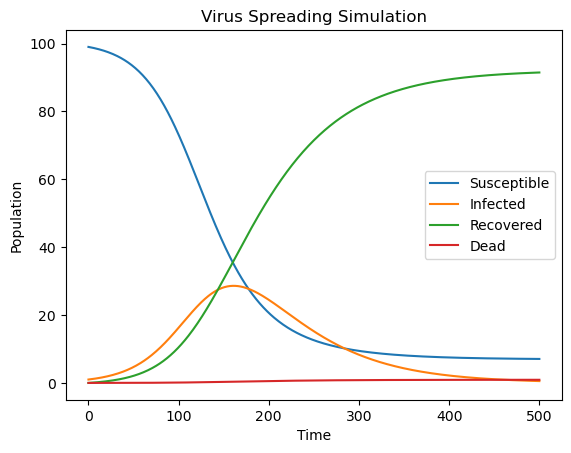

array([[0.00000000e+00, 9.90000000e+01, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 9.89497125e+01, 1.03250458e+00, 1.76050986e-02,
        1.77829279e-04],
       [2.00000000e+00, 9.88978178e+01, 1.06603849e+00, 3.57822227e-02,
        3.61436593e-04],
       ...,
       [4.98000000e+02, 7.07052083e+00, 5.57978699e-01, 9.14477855e+01,
        9.23715005e-01],
       [4.99000000e+02, 7.06856221e+00, 5.50240556e-01, 9.14573853e+01,
        9.23811972e-01],
       [5.00000000e+02, 7.06663128e+00, 5.42609200e-01, 9.14668519e+01,
        9.23907595e-01]])

In [19]:
#Data geneation and export 
beta = 0.0005
sim_virus_spreading(beta, True)

In [20]:
# Define the directory where the data will be saved
output_dir = '../2020 DL data'

# Create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

countries = 125
verbose = False
export_raw_data = True

if verbose:
    countries = 1

if export_raw_data:
    raw_features = np.zeros((4 * countries + 1, 501))
    raw_features[0, :] = np.arange(501)

features = np.zeros((countries, 8))
np.random.seed(0)  # For reproducibility
betas = np.random.normal(0.0005, 0.0001, countries)

for i in range(countries):
    res = sim_virus_spreading(betas[i], False)
    times = res[:, 0]
    # Add randomness to the observations
    rand_res = np.zeros((res.shape[0], 5))
    rand_res[:, 0] = times
    for j in range(1, 5):
        rand_res[:, j] = np.array([np.random.normal(0, 0.025 * x) + x for x in res[:, j]])

    if verbose:
        print(f"Beta = {betas[i] * 100:.3f}%")
        plt.plot(times, np.column_stack([res[:, 1], rand_res[:, 1], res[:, 2], rand_res[:, 2], res[:, 3], rand_res[:, 3], res[:, 4], rand_res[:, 4]]))
        plt.show()

    if export_raw_data:
        days = np.arange(501)
        for var in range(1, 5):
            F = interp1d(rand_res[:, 0], rand_res[:, var], fill_value="extrapolate")
            raw_features[(i * 4) + var, :] = F(days)

    ti = times[times <= 50]
    n_50 = rand_res[len(ti) - 1, 2]
    d_50 = rand_res[len(ti) - 1, 2] - rand_res[len(ti) - 2, 2]
    ti = times[times <= 150]
    n_150 = rand_res[len(ti) - 1, 2]
    d_150 = rand_res[len(ti) - 1, 2] - rand_res[len(ti) - 2, 2]
    ti = times[times <= 300]
    n_300 = rand_res[len(ti) - 1, 2]
    d_300 = rand_res[len(ti) - 1, 2] - rand_res[len(ti) - 2, 2]
    t_peak = times[np.argmax(rand_res[:, 2])]

    if verbose:
        print(f"n_50={n_50:.4f}, n_150={n_150:.4f}, n_300={n_300:.4f}\nd_50={d_50:.4f}, d_150={d_150:.4f}, d_300={d_300:.4f}\nt_peak={t_peak:.4f}\nx_500={rand_res[-1, 4]:.4f}")

    features[i, :] = [n_50, n_150, n_300, d_50, d_150, d_300, t_peak, rand_res[-1, 4]]

df_features = pd.DataFrame(features)
df_features.to_csv(os.path.join(output_dir, 'epidemic_process.csv'), index=False)

if export_raw_data:
    df_raw_features = pd.DataFrame(raw_features)
    df_raw_features.to_csv(os.path.join(output_dir, 'epidemic_process_raw_data.csv'), index=False)

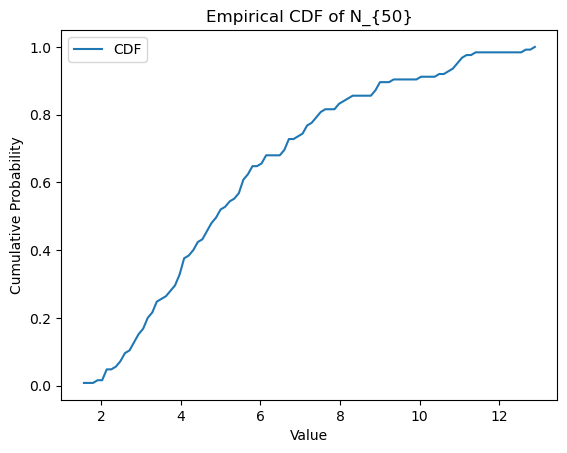

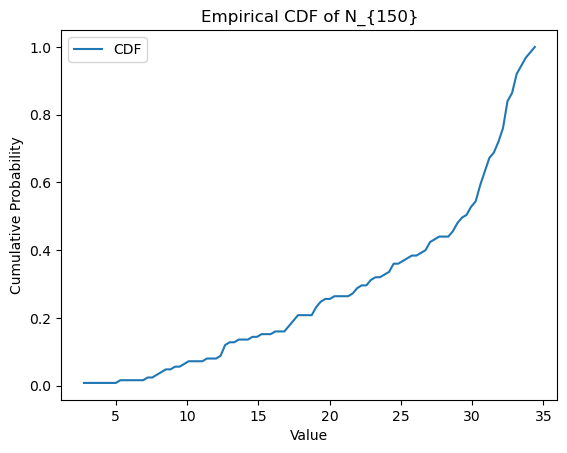

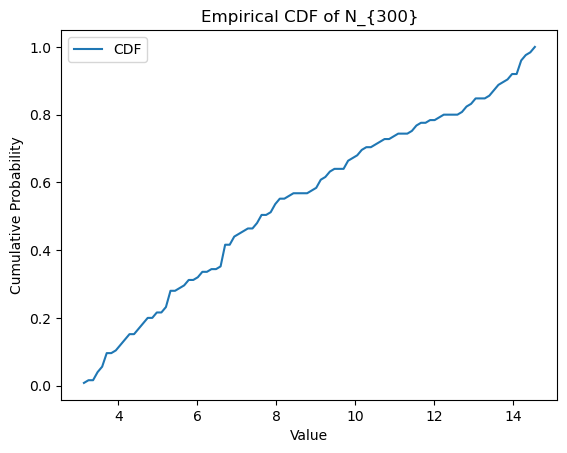

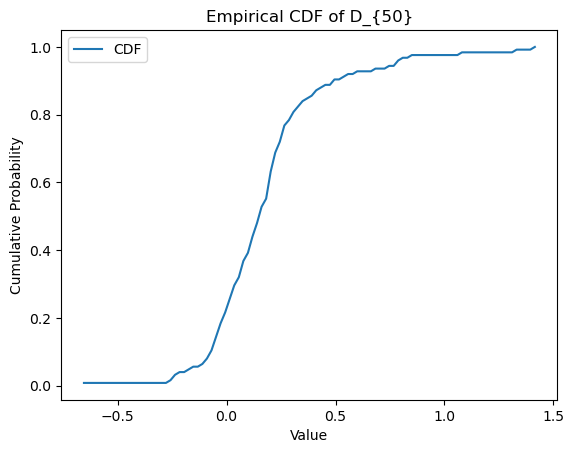

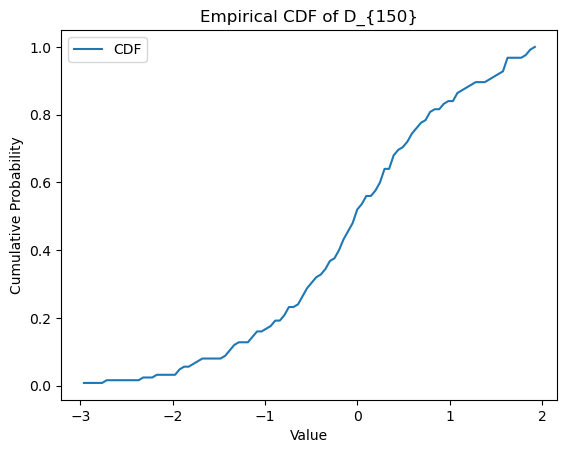

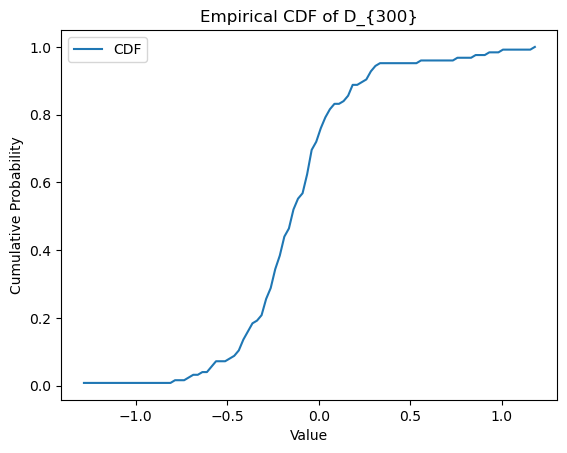

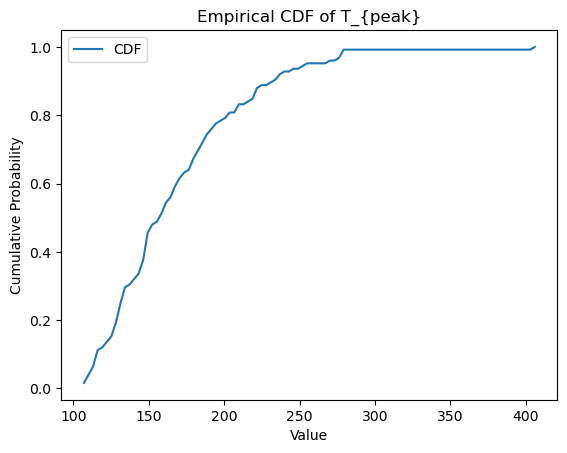

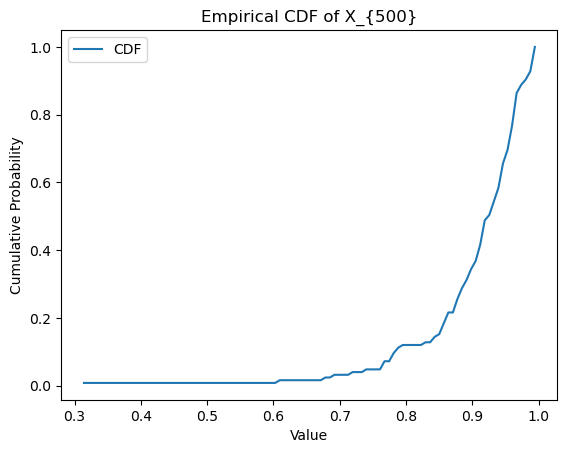

In [21]:
#1.3 Load the generated data
features = pd.read_csv("../2020 DL data/epidemic_process.csv")

def plot_cdf(feature, title):
    count, bins_count = np.histogram(feature, bins=100)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.show()

plot_cdf(features.iloc[:, 0], "Empirical CDF of N_{50}")
plot_cdf(features.iloc[:, 1], "Empirical CDF of N_{150}")
plot_cdf(features.iloc[:, 2], "Empirical CDF of N_{300}")
plot_cdf(features.iloc[:, 3], "Empirical CDF of D_{50}")
plot_cdf(features.iloc[:, 4], "Empirical CDF of D_{150}")
plot_cdf(features.iloc[:, 5], "Empirical CDF of D_{300}")
plot_cdf(features.iloc[:, 6], "Empirical CDF of T_{peak}")
plot_cdf(features.iloc[:, 7], "Empirical CDF of X_{500}")

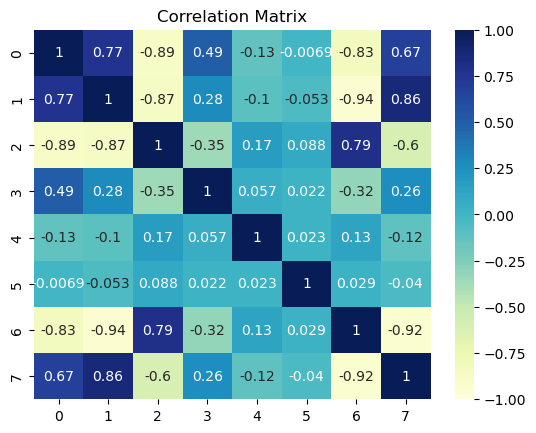

In [22]:
rho = np.corrcoef(features, rowvar=False)
sns.heatmap(rho, vmin=-1, vmax=1, cmap="YlGnBu",annot=True)
plt.title('Correlation Matrix')
plt.show()

best_fit_n_50, p_value_n_50
gamma with 1.00 p-value


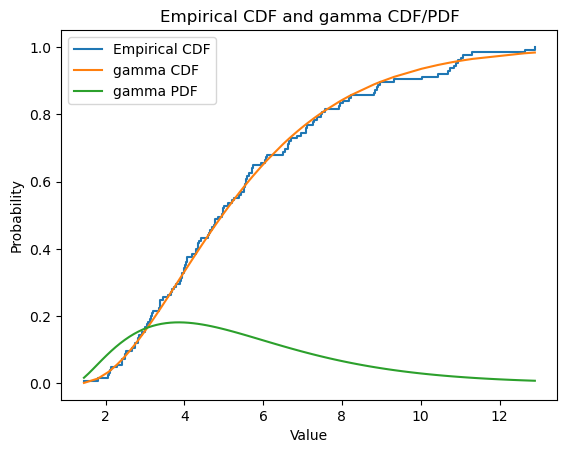


best_fit_n_150, p_value_n_150
norm with 0.00 p-value


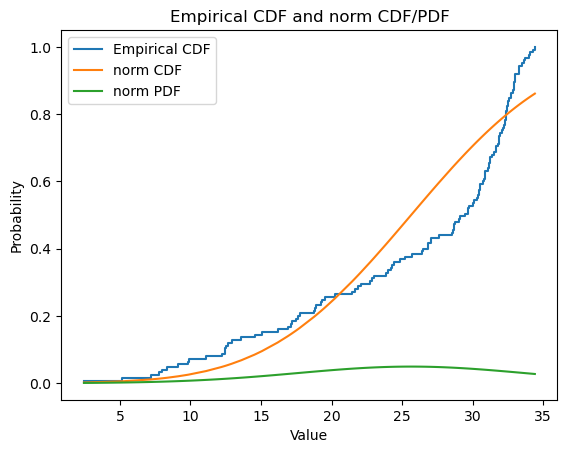


best_fit_n_300, p_value_n_300
lognorm with 0.43 p-value


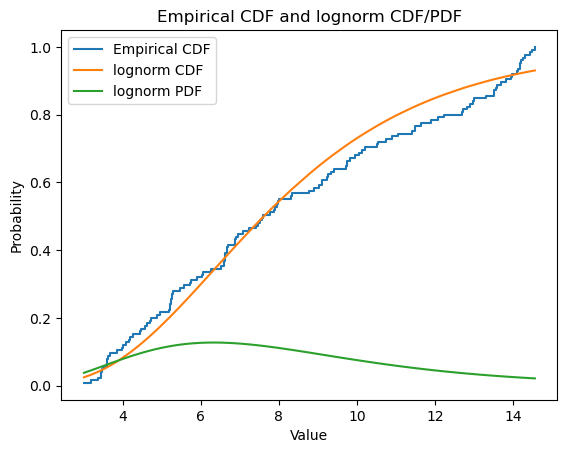


best_fit_d_50, p_value_d_50
lognorm with 0.05 p-value


C:\Users\emadi\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


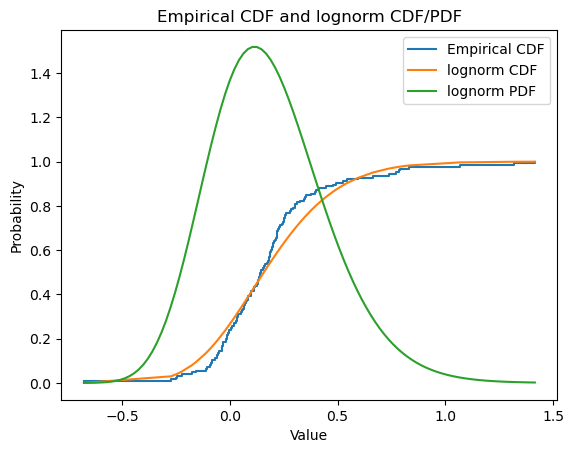


 best_fit_d_150, p_value_d_150
norm with 0.90 p-value


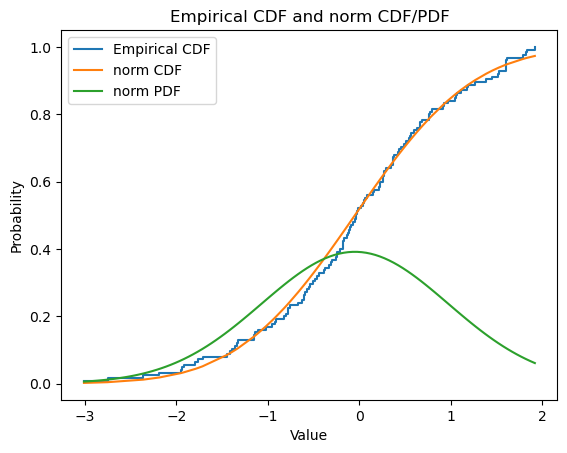


best_fit_d_300, p_value_d_300
lognorm with 0.07 p-value


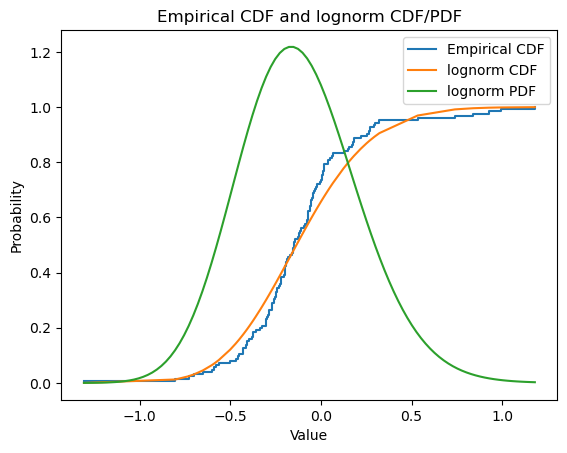


best_fit_t_peak, p_value_t_peak
gamma with 0.97 p-value


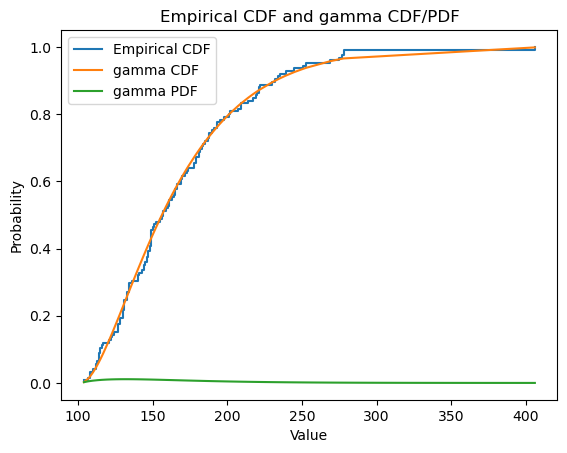


best_fit_x_500, p_value_x_500
norm with 0.01 p-value


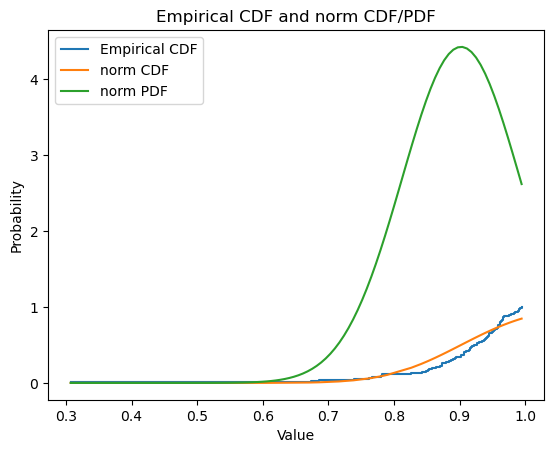

In [23]:
def distribution_fitting(feature):
    distnames = ["norm", "expon", "gamma", "lognorm"]
    x = feature
    x_values = np.linspace(min(x), max(x), 100)
    
    best_fit_name = None
    best_p_value = 0
    best_params = None

    for distname in distnames:
        dist = getattr(stats, distname)
        params = dist.fit(x)
        
        # Kolmogorov-Smirnov test
        res1 = stats.kstest(x, distname, args=params)
        
        if res1.pvalue > best_p_value:
            best_fit_name = distname
            best_p_value = res1.pvalue
            best_params = params

    # Plotting the best fit distribution
    if best_fit_name:
        print(f'{best_fit_name} with {best_p_value:.2f} p-value')
        plt.figure()
        
        # Empirical CDF
        ecdf = np.arange(1, len(x)+1) / len(x)
        plt.step(np.sort(x), ecdf, where='post', label='Empirical CDF')
        
        # Best fit CDF
        dist = getattr(stats, best_fit_name)
        cdf_values = dist.cdf(np.sort(x), *best_params[:-2], loc=best_params[-2], scale=best_params[-1])
        plt.plot(np.sort(x), cdf_values, label=f'{best_fit_name} CDF')

        # Best fit PDF
        pdf_values = dist.pdf(x_values, *best_params[:-2], loc=best_params[-2], scale=best_params[-1])
        plt.plot(x_values, pdf_values, label=f'{best_fit_name} PDF')
        
        plt.title(f"Empirical CDF and {best_fit_name} CDF/PDF")
        plt.xlabel('Value')
        plt.ylabel('Probability')
        plt.legend()
        plt.show()

    return best_fit_name, best_p_value



# Example usage:
print("best_fit_n_50, p_value_n_50")
best_fit_n_50, p_value_n_50 = distribution_fitting(features.iloc[:, 0])
print("\nbest_fit_n_150, p_value_n_150")
best_fit_n_150, p_value_n_150 = distribution_fitting(features.iloc[:, 1])
print("\nbest_fit_n_300, p_value_n_300")
best_fit_n_300, p_value_n_300 = distribution_fitting(features.iloc[:, 2])
print("\nbest_fit_d_50, p_value_d_50")
best_fit_d_50, p_value_d_50 = distribution_fitting(features.iloc[:, 3])
print("\n best_fit_d_150, p_value_d_150")
best_fit_d_150, p_value_d_150 = distribution_fitting(features.iloc[:, 4])
print("\nbest_fit_d_300, p_value_d_300")
best_fit_d_300, p_value_d_300 = distribution_fitting(features.iloc[:, 5])
print("\nbest_fit_t_peak, p_value_t_peak")
best_fit_t_peak, p_value_t_peak = distribution_fitting(features.iloc[:, 6])
print("\nbest_fit_x_500, p_value_x_500")
best_fit_x_500, p_value_x_500 = distribution_fitting(features.iloc[:, 7])

In [24]:
# Load the features DataFrame
features = pd.read_csv('epidemic_process.csv')

# Extract the necessary columns
n_50 = features.iloc[:, 0]
x_500 = features.iloc[:, 7]

# Calculate the joint probability P(N50 <= 4%, X500 > 0.95%)
positive_cases = len(np.intersect1d(np.where(n_50 <= 4)[0], np.where(x_500 > 0.95)[0]))
all_cases = len(features)
P_joint = positive_cases / all_cases

# Calculate the product of the probabilities P(N50 <= 4%) and P(X500 > 0.95%)
P_N50_4 = len(np.where(n_50 <= 4)[0]) / all_cases
P_X500_95 = len(np.where(x_500 > 0.95)[0]) / all_cases
P_product = P_N50_4 * P_X500_95

# Calculate the conditional probability P(X500 > 0.95% | N50 <= 4%)
mild_start_cases = len(np.where(n_50 <= 4)[0])
P_conditional = positive_cases / mild_start_cases

# Print results
print(f'P(N50 <= 4%, X500 > 0.95%) = {P_joint:.4f}')
print(f'P(N50 <= 4%) * P(X500 > 0.95%) = {P_product:.4f}')
print(f'P(X500 > 0.95% | N50 <= 4%) = {P_conditional:.4f}')

P(N50 <= 4%, X500 > 0.95%) = 0.0204
P(N50 <= 4%) * P(X500 > 0.95%) = 0.1416
P(X500 > 0.95% | N50 <= 4%) = 0.0588


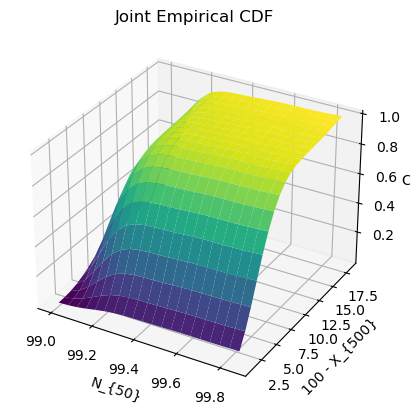

In [10]:
# Function to compute the joint CDF on a grid
def joint_cdf(x, y, xbins, ybins):
    data = np.vstack([x, y])
    kde = gaussian_kde(data)
    xi, yi = np.meshgrid(xbins, ybins)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
    zi = zi.reshape(xi.shape)
    cdf = np.cumsum(zi, axis=1)
    cdf = np.cumsum(cdf, axis=0)
    cdf = cdf / cdf.max()
    return xi, yi, cdf

n_50 = features.iloc[:, 0]
x_500 = 100 - features.iloc[:, 7]

# Create bins
xbins = np.linspace(min(n_50), max(n_50), 20)
ybins = np.linspace(min(x_500), max(x_500), 20)

# Compute the joint CDF
xi, yi, joint_CDF = joint_cdf(n_50, x_500, xbins, ybins)

# Plot the surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(yi, xi, joint_CDF, cmap='viridis')
ax.set_title('Joint Empirical CDF')
ax.set_xlabel('N_{50}')
ax.set_ylabel('100 - X_{500}')
ax.set_zlabel('CDF')
plt.show()


In [25]:
def plotPDF(xi, pd_fit, PDF):
    plt.figure()
    plt.plot(xi, PDF(xi), label='Parzen PDF')
    plt.plot(xi, pd_fit.pdf(xi), label='Fit PDF')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Parzen Window Density Estimation')
    plt.show()

In [26]:
def samplePDF(sample, pd_fit, dist_name, verbose=False):
    kde = gaussian_kde(sample)
    xi = np.linspace(min(sample), max(sample), 100)
    pdf_values = kde(xi)
    PDF = interp1d(xi, pdf_values, fill_value="extrapolate")
    
    if verbose:
        fitted_pdf = pd_fit.pdf(xi)
        plotPDF(xi, pdf_values, fitted_pdf, dist_name)
    
    return PDF

In [27]:
def parzanPDF(sample, pd_fit, a, b, h, verbose=False):
    x = np.arange(a, b, 0.1)
    mu = 0
    sigma = 1
    len_x = len(x)
    len_s = len(sample)
    f = np.zeros(len_x)
    
    for j in range(len_x):
        xi = x[j]
        # Use a Gaussian Kernel function
        for i in range(len_s):
            f[j] += norm.pdf((xi - sample[i]) / h, mu, sigma)
        f[j] /= (len_s * h)
    
    PDF = interp1d(x, f, kind='linear', fill_value="extrapolate")
    
    if verbose:
        plotPDF(x, pd_fit, PDF)
    
    return PDF


In [42]:
n_50 = features.iloc[:, 0]
pd_n_50 = stats.norm.fit(n_50)

# Create the empirical PDF using Parzen window and plot if verbose is True
PDF_n_50 = parzanPDF(n_50, stats.norm(loc=pd_n_50[0], scale=pd_n_50[1]), a=0, b=25, h=0.9, dist_name='Normal', verbose=True)

# You can now use `PDF_n_50` as an interpolant to get the PDF values for any x
x_values = np.linspace(min(n_50), max(n_50), 100)
pdf_values = PDF_n_50(x_values)
plt.plot(x_values, pdf_values, label='Interpolated Empirical PDF')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Interpolated Empirical PDF')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [43]:
PDF_n_50 = parzanPDF(n_50, pd_n_50, 0, 25, 0.9, verbose=True)

TypeError: parzanPDF() got an unexpected keyword argument 'verbose'

In [31]:
# Load the data
features = pd.read_csv('epidemic_process.csv').values

# Joint and conditional probabilities, chain rule and Bayes’ Theorem

# Calculate the joint probability
n_50 = features[:, 0]
x_500 = features[:, 7]
indices_n_50 = np.where(n_50 <=4)[0]
indices_x_500 = np.where(x_500 > 0.95)[0]
positive_cases = len(np.intersect1d(indices_n_50, indices_x_500))
all_cases = len(features)
P = positive_cases / all_cases
print("P (N50 ≤ 4%, X500 > 0.95%) ≈", P)  # Expected to be approximately 0.008

# Calculate the product of the two probabilities
P2 = (len(indices_n_50) / all_cases) * (len(np.where(x_500 > 0.95)[0]) / all_cases)
print("Product of the two probabilities P (N50 ≤ 4%)P (X500 > 0.95%) =", P2)  # This product should be around 0.1263


# Calculate the conditional probability
mild_start_cases = len(np.where(n_50 <= 4)[0])
P_AB = positive_cases / mild_start_cases
print("P (X500 > 0.95%|N50 ≤ 4%) ≈", P_AB)  # Expected to be approximately 0.0213


# Verify the chain rule
P_B = mild_start_cases / all_cases
P_chain_rule = P_AB * P_B
print("P (X500 > 0.95%, N50 ≤ 4%) from chain rule =", P_chain_rule)  # Should be the same as P


# Verify Bayes’ Theorem
disaster_cases = len(np.where(x_500 > 0.95)[0])
P_A = disaster_cases / all_cases
P_BA = positive_cases / disaster_cases
P_AB_bayes = P_BA * P_A / P_B
print("P (X500 > 0.95%|N50 ≤ 4%) from Bayes’ Theorem ≈", P_AB_bayes)  # Should match the earlier conditional probability


P (N50 ≤ 4%, X500 > 0.95%) ≈ 0.02040816326530612
Product of the two probabilities P (N50 ≤ 4%)P (X500 > 0.95%) = 0.1416076634735527
P (X500 > 0.95%|N50 ≤ 4%) ≈ 0.058823529411764705
P (X500 > 0.95%, N50 ≤ 4%) from chain rule = 0.02040816326530612
P (X500 > 0.95%|N50 ≤ 4%) from Bayes’ Theorem ≈ 0.05882352941176471


### 1.6 Self-entropy of an event and entropy of a distribution

In [35]:
## Trapzoid and simpson's 3/8 rule.
def trapez(f, a, b):
    N = (b-a)*100
    x = np.linspace(a, b, N)
    dx = x[1] - x[0]
    
    y = np.array([f(xi) for xi in x])
    
    w = np.ones(N)
    w[0] = 0.5
    w[-1] = 0.5
    
    I = np.sum(w * y) * dx
    
    return I

def simpson(f, a, b):
    N = 3 * int((b - a) * 100) + 1
    x = np.linspace(a, b, N)
    dx = x[1] - x[0]
    I = 0
    
    for i in range(0, N-3, 3):
        z0 = f(x[i])
        z1 = f(x[i+1])
        z2 = f(x[i+2])
        z3 = f(x[i+3])
        I += z0 + 3 * z1 + 3 * z2 + z3
    
    I *= 3 * dx / 8
    return I


In [36]:
def ite(b, t, f):
    if b:
        return t
    else:
        return f

In [44]:
# Define the range
a = -25
b = 25

# Define the functions
f1 = lambda x: ite(PDF_n_50(x) <= 0, 0, PDF_n_50(x))
entropy1 = lambda x: -1 * ite(PDF_n_50(x) <= 0, 0, PDF_n_50(x) * np.log(PDF_n_50(x)))

# Calculate the integrals
Integral1 = trapez(f1, a, b)
Entropy1 = trapez(entropy1, a, b)

print("Integral1 =", Integral1)
print("Entropy1 =", Entropy1)

Integral1 = 0.9999999599838199
Entropy1 = 1.716551534818161
